In [ ]:
import torch
from torch import nn
from torch.optim import Adam, SGD
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms as tf
from torchvision.utils import save_image, make_grid

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Architecture Overview

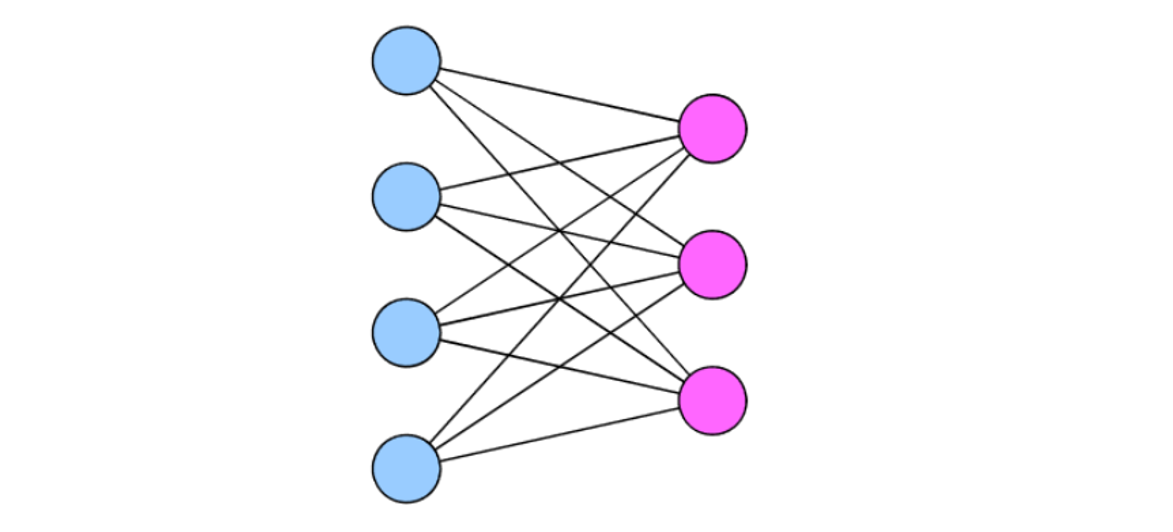

$p_\theta(\mathbf{v, h}) = \frac{1}{Z}\mathrm{exp}(-E_\theta(\mathbf{v, h}))$

$Z = \sum_{\mathbf{v', h'}}\mathrm{exp}(-E_\theta(\mathbf{v, h}))$

$E_\theta(\mathbf{v, h}) = -\bigg(\mathbf{c}^T\mathbf{v} + \mathbf{b}^T\mathbf{h} +\ \mathbf{h^TWx} \bigg)$

# Contrastive Divergence

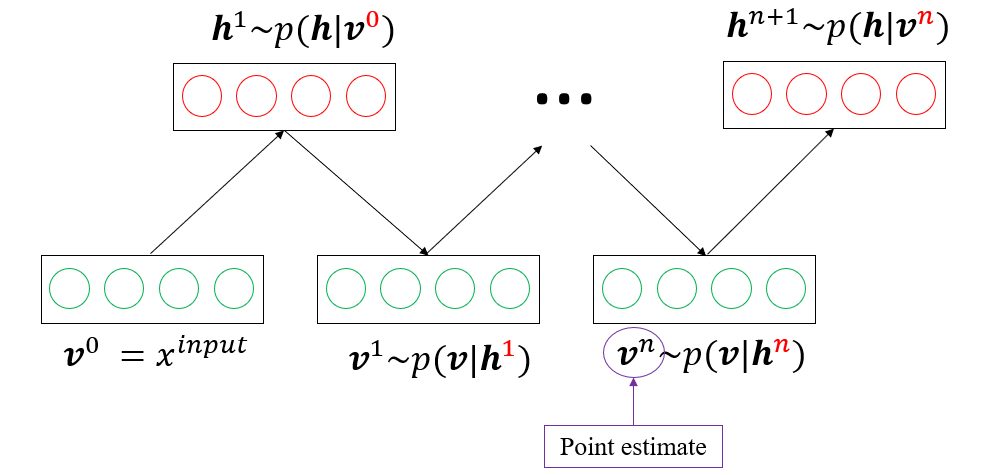

$\mathbb{E}_{p(\mathbf{h|v})}[\nabla_\mathbf{W}E_\theta(\mathbf{v, h})]\ =\ -\mathbf{h(v)v^T}$

 

$\mathbf{h(v)}\ =\ \begin{bmatrix} 
p(h_0 = 1 | \mathbf{v}) \\
p(h_1 = 1 | \mathbf{v}) \\
. \\
. \\
. \\
p(h_m = 1 | \mathbf{v}) \\
\end{bmatrix} $

 

$\Delta\mathbf{W}\ =\ \eta \cdot (\mathbf{h}(\mathbf{v}_{data})\mathbf{v}_{data}^T\ -\ \mathbf{h}(\mathbf{v}_{model})\mathbf{v}_{model}^T)$

The method torch.bernoulli(x) draws binary random numbers (0 or 1) from a Bernoulli distribution.

The input tensor should be a tensor containing probabilities to be used for drawing the binary random number.

$out_i\ ∼\ Bernoulli(p=input_i​)$

The returned $out$ tensor only has values 0 or 1 and is of the same shape as $input$

# Init dataset

In [ ]:
kwargs = {'batch_size': 256, 'num_workers': 8, 'pin_memory': True}

train_loader = DataLoader(
                    MNIST('./mnist', train=True, download=True, transform=tf.ToTensor()),
                    shuffle=True, 
                    **kwargs
                )
test_loader = DataLoader(
                    MNIST('./mnist', train=False, download=True, transform=tf.ToTensor()),
                    **kwargs
                )

# Model Implementation

In [ ]:
class RBM():
    """The binary RBM class.

    """
    def __init__(self, n_h=100, n_v=784, lr=1.e-2, gibbs_iterations=1, device='cpu'):
        self.gibbs_iterations = gibbs_iterations
        self.device = device
        # Manually specify optimization properties
        self.lr = lr
        self.momentum = 0.7
        self.wd = 1.e-4
        # Init the model paramters
        self.weights = torch.randn(n_v, n_h, device=device)
        self.bias_v  = torch.zeros(n_v, device=device)
        self.bias_h  = torch.zeros(n_h, device=device)
        #
        self.w_momentum      = torch.zeros(n_v, n_h, device=device)
        self.bias_v_momentum = torch.zeros(n_v, device=device)
        self.bias_h_momentum = torch.zeros(n_h, device=device)

    def get_parameters_dict(self):
        """
        Create a dictionary containing all the model parameters

        """
        return dict(
            weights=self.weights,
            bias_v=self.bias_v,
            bias_h=self.bias_h,
            w_momentum=self.w_momentum,
            bias_v_momentum=self.bias_v_momentum,
            bias_h_momentum=self.bias_h_momentum,
            gibbs_iterations=self.gibbs_iterations
        )

    def load_parameters(self, d):
        """"
        Load the model parameters from a dictionary

        """
        self.weights=d['weights']
        self.bias_v=d['bias_v']
        self.bias_h=d['bias_h']
        self.w_momentum=d['w_momentum']
        self.bias_v_momentum=d['bias_v_momentum']
        self.bias_h_momentum=d['bias_h_momentum']
        self.gibbs_iterations=d['gibbs_iterations']
        print('All keys loaded successfully')

    def sample_v_from_h(self, h):
        """
        We are not really sampling, we are evaluating p(v|h)
        
        """
        return torch.sigmoid(F.linear(input=h, weight=self.weights, bias=self.bias_v))
    
    def sample_h_from_v(self, v):
        """
        We are not really sampling, we are evaluating p(h|v)

        """
        return torch.sigmoid(F.linear(input=v, weight=self.weights.t(), bias=self.bias_h))

    def contrastive_divergence(self, v):
        """
        The CD accounts for the two steps: the positive and the negative phases

        """
        batch_size = v.shape[0]
        v = v.view(batch_size, -1)

        ## Positive phase 
        hidden_probabilities = self.sample_h_from_v(v)
        h_activated = hidden_probabilities.bernoulli()
        
        # Expected value for the positive phase
        expected_value_positive_phase = torch.matmul(v.t(), hidden_probabilities)

        ## Negative phase
        h_gibbs_activated = h_activated
        
        # Gibbs Sampling
        for _ in range(self.gibbs_iterations):
            v_gibbs = self.sample_v_from_h(h_gibbs_activated).bernoulli()
            h_gibbs_probabilities = self.sample_h_from_v(v_gibbs)
            h_gibbs_activated = h_gibbs_probabilities.bernoulli()
        
        # Expected value for the negative phase
        expected_value_negative_pshase = torch.matmul(v_gibbs.t(), h_gibbs_probabilities)
        
        ###########################
        #### Parameters Update ####
        ###########################
        # Replace the gradient computation by a “leaky average”
        self.w_momentum *= self.momentum # The first time the w_momentum is = 0
        self.w_momentum += (expected_value_positive_phase - expected_value_negative_pshase)

        self.bias_v_momentum *= self.momentum
        self.bias_v_momentum += torch.sum(v - v_gibbs, dim=0)

        self.bias_h_momentum *= self.momentum
        self.bias_h_momentum += torch.sum(hidden_probabilities - h_gibbs_probabilities, dim=0)

        self.weights += self.w_momentum      * self.lr / batch_size
        self.bias_v  += self.bias_v_momentum * self.lr / batch_size
        self.bias_h  += self.bias_h_momentum * self.lr / batch_size

        # ... don't forget to (L2) regularize the weights
        self.weights -= self.weights * self.wd 

        # Return the reconstruction error
        return ((v - v_gibbs)**2).sum()

    def generate_data(self, v, g_iter=-1):
        # Gibbs Sampling
        h_gibbs = self.sample_h_from_v(v)
        g_iterations = self.gibbs_iterations if g_iter == -1 else g_iter
        for _ in range(g_iterations):
            v_gibbs = self.sample_v_from_h(h_gibbs.bernoulli())
            h_gibbs = self.sample_h_from_v(v_gibbs.bernoulli())
        return v_gibbs.bernoulli()

In [ ]:
# Init the model
model = RBM(lr=1.e-2, gibbs_iterations=1, device=device)

In [ ]:
def train(epoch):
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader, 1):
        data = data.to(device).bernoulli()
        
        train_loss += model.contrastive_divergence(data)

        if batch_idx % (len(train_loader)//3) == 0:
            print(
              f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
              f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {train_loss / batch_idx:.6f}'
          )
  
    print(
        f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader):.4f}'
    )

In [ ]:
# Train the model
[train(epoch) for epoch in range(1, 200)]

In [ ]:
# Save model checkpoint
torch.save(model.get_parameters_dict(), './rbm.pth')

In [ ]:
# Load model checkpoint
model.load_parameters(torch.load('./rbm.pth'))

# Inference

In [ ]:
batch = next(iter(train_loader))[0]
images = batch[:96]

In [ ]:
# show the real images
plt.figure(figsize=(20, 10))
npimg = np.transpose(make_grid(images, nrow=24), (1, 2, 0))
plt.imshow(npimg, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# Generate new images
v_gibbs  = model.generate_data(images.to(device).bernoulli().view(images.shape[0], -1))

In [ ]:
# show the generated images
plt.figure(figsize=(20, 10))
img = make_grid(v_gibbs.view(images.shape[0], 1, 28, 28).data, nrow=24)
npimg = np.transpose(img.detach().cpu().numpy(), (1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.imshow(npimg, cmap='gray')
plt.show()

# RBM as features extractor

In [ ]:
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
def extr_features(loader, loader_type):
    """
    Extract features

    """
    features = []
    labels = []
    desc = f'Extr. features from {loader_type} data'
    for i, (x, y) in enumerate(tqdm(loader, total=len(loader), desc=desc)):
        x = x.view(x.shape[0], -1).to(device)
        features.append(model.sample_h_from_v(x).cpu().numpy())
        labels.extend(y.numpy().tolist())
    features = np.vstack([t_ for t_ in features])
    labels = np.asarray(labels)
    return features, labels

In [ ]:
train_features, train_labels = extr_features(train_loader, loader_type='TRAIN')
test_features, test_labels = extr_features(test_loader, loader_type='TEST')

In [ ]:
print(f'TRAIN dataset:\n\t Features: {train_features.shape} -- Labels: {train_labels.shape}')
print(f'TEST dataset:\n\t Features: {test_features.shape} -- Labels: {test_labels.shape}')

In [ ]:
# Init the classifier to train with the extracted features
clf = LogisticRegression(max_iter=1000)

In [ ]:
# Fit the classifier
clf.fit(train_features, train_labels);

In [ ]:
# Predict labels for the test features set
predictions = clf.predict(test_features)

print(test_labels[:10])
print(predictions[:10])

In [ ]:
# Print the classifier performance
print(f'Test Accuracy: {sum(predictions == test_labels)/len(test_labels) * 100:.2f}%') 

In [ ]:
confusion_matrix(test_labels, predictions)

In [ ]:
print(f'{accuracy_score(test_labels, predictions)*100:.2f}%')

# Features visualization

In [ ]:
print(model.weights.shape)

In [ ]:
# Visualize the first 60 feature detectors, i.e, the incoming weights to the first 60 hidden units. 
fig = plt.figure(3, figsize=(15,10))
for i in range(60): 
    sub = fig.add_subplot(6, 10, i+1)
    sub.imshow(model.weights[:, i].detach().cpu().numpy().reshape((28,28)), cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])

# Free Energy Formulation

$p_\theta(\mathbf{v}) = \frac{1}{Z}\mathrm{exp}(-F_\theta(\mathbf{v}))$

$Z = \sum_{\mathbf{v'}}\mathrm{exp}(-F_\theta(\mathbf{v}))$

$F_\theta(\mathbf{v}) = -\Bigg(\mathbf{c}^T\mathbf{v} + \sum_i\mathrm{log}(1\ +\ \mathrm{exp}(\mathbf{W}_i\mathbf{v}\ +\ \mathbf{c}_i)) \Bigg)$

In [ ]:
class FreeRBM(nn.Module):
    def __init__(self):
        super(FreeRBM, self).__init__()
        self.n_h, self.n_v = 150, 784
        self.gibbs_iterations = 1
        # Init the model graph
        self.weights = nn.Parameter(torch.randn(self.n_h, self.n_v))
        self.bias_v  = nn.Parameter(torch.zeros(self.n_v))
        self.bias_h  = nn.Parameter(torch.zeros(self.n_h))

    def sample_v_from_h(self, h):
        """
        Sample from p(v|h)

        """
        probs = torch.sigmoid(F.linear(input=h, weight=self.weights.t(), bias=self.bias_v))
        return probs.bernoulli()

    def sample_h_from_v(self, v):
        """
        Sample from p(h|v)

        """
        probs = torch.sigmoid(F.linear(input=v, weight=self.weights, bias=self.bias_h))
        return probs.bernoulli()

    def eval_free_energy(self, v):
        """
        Eval the free energy 

        """
        ctv = -torch.matmul(v, self.bias_v.t())
        v_lin_transf = F.linear(v, self.weights, self.bias_h)
        marg_h = -torch.sum(F.softplus(v_lin_transf), dim=1)
        return torch.mean(marg_h + ctv)

    def forward(self, v):
        h = self.sample_h_from_v(v)
        for _ in range(self.gibbs_iterations):
            v_gibb = self.sample_v_from_h(h)
            h = self.sample_h_from_v(v_gibb)
        return v, v_gibb

In [ ]:
free_rbm = FreeRBM()
free_rbm.to(device)

In [ ]:
optimizer = Adam(free_rbm.parameters(), lr=1.e-2)

In [ ]:
def train(epoch):
    free_rbm.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader, 1):
        data = data.to(device).bernoulli()
        
        v, v_gibbs = free_rbm(data.view(-1, 784))

        loss = free_rbm.eval_free_energy(v) - free_rbm.eval_free_energy(v_gibbs)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % (len(train_loader)//3) == 0:
            print(
              f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
              f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {train_loss / batch_idx:.6f}'
          )
  
    print(
        f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader):.4f}'
    )

In [ ]:
# Train the model
[train(epoch) for epoch in range(1, 5)]

In [ ]:
# Save model checkpoint
torch.save(free_rbm.state_dict(), './free_rbm.pth')

In [ ]:
# Load model
free_rbm.load_state_dict(torch.load('./free_rbm.pth'))

# Inference

In [ ]:
batch = next(iter(train_loader))[0]
images = batch[:96]

In [ ]:
# show the real images
plt.figure(figsize=(20, 10))
npimg = np.transpose(make_grid(images, nrow=24), (1, 2, 0))
plt.imshow(npimg, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# Generate new images
_, v_gibbs = free_rbm(images.to(device).bernoulli().view(images.shape[0], -1))

In [ ]:
# show the generated images
plt.figure(figsize=(20, 10))
img = make_grid(v_gibbs.view(images.shape[0], 1, 28, 28).data, nrow=24)
npimg = np.transpose(img.detach().cpu().numpy(), (1, 2, 0))
plt.imshow(npimg, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

# Look at some learned features

In [ ]:
print(free_rbm.weights.shape)

In [ ]:
# Visualize the first 50 feature detectors, i.e, the incoming weights to the first 50 hidden units. 
fig = plt.figure(3, figsize=(20,10))
for i in range(50): 
    sub = fig.add_subplot(5, 10, i+1)
    sub.imshow(free_rbm.weights[i].detach().cpu().numpy().reshape((28,28)), cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])